In [35]:
import torch
import torch.nn as nn
from itertools import combinations_with_replacement

def quantize(x, bits, dev = 'cpu'):
    maxq = torch.tensor(2**bits - 1)

    tmp = torch.zeros(x.shape[0], device=dev)
    xmin = torch.minimum(x.min(1)[0], tmp) #Rowwise minimums
    xmax = torch.maximum(x.max(1)[0], tmp) #Rowwise minimums

    tmp = (xmin == 0) & (xmax == 0)
    xmin[tmp] = -1
    xmax[tmp] = +1

    if maxq < 0:
        scale = xmax
        zero = xmin
    else:
        scale = (xmax - xmin) / maxq
        zero = torch.round(-xmin / scale)

    if maxq < 0:
        return (x > scale / 2).float() * scale + (x < zero / 2).float() * zero
    
    q = torch.clamp(torch.round(x / scale) + zero, 0, maxq)
    return scale * (q - zero)

def find_combinations(n):
    target_sum = 4 * n
    result = []

    # Generate possible values for the integers (1 to target_sum)
    possible_values = range(1, target_sum + 1)

    # Use combinations_with_replacement to generate combinations with non-increasing order
    for combo in combinations_with_replacement(possible_values, 4):
        if sum(combo) == target_sum:
            # Reverse to ensure the order is non-increasing
            sorted_combo = tuple(sorted(combo, reverse=True))
            result.append(sorted_combo)

    return result

Greedy column reordering and quantization

In [9]:
#torch.manual_seed(0)
winners = 0
for i in range(1000):
    size = 100

    #Split quantization without reordering
    A = torch.randn(size,size)
    B = torch.randn(size,size)
    B2 = torch.clone(B)
    out = torch.matmul(A,B)

    B4 = quantize(B,4)
    B8 = quantize(B,8)
    
    B[:,size//2:size] = B4[:,size//2:size]
    B[:,:size//2] = B8[:,:size//2] 

    test_out = torch.matmul(A,B)

    #Find largest columns by means
    largest_col = torch.argsort(-torch.mean(A,axis=0))

    #Reorder columns according to their mean
    A = A[:,largest_col] 
    B = B2[largest_col,:]

    B4 = quantize(B,4)
    B8 = quantize(B,8)
    
    B[:,size//2:size] = B4[:,size//2:size]
    B[:,:size//2] = B8[:,:size//2] 

    quantOut = torch.matmul(A,B)

    error = torch.norm(out - test_out) 
    error2 = torch.norm(out - quantOut)  
    winners = winners+1 if error2>error else winners
    
print(winners)

#2.8505
#2.8109

520


Now test with different blocks

In [62]:
#Split matrix in 4 blocks
import numpy as np

base_quant = 4
combinations = find_combinations(base_quant)
expansion_factors = [1.05,1.25,1.5,1.75,2,2.5,3,5,7.5,10]
best_combinations = []
best_scores = []
for expansion_factor in expansion_factors:
    best_comb = None
    best_score = 0
    for comb in combinations:
        curr_error = []
        for i in range(50):
            A = torch.rand(100,100) 
            top_left = torch.rand(50,50)*expansion_factor**3 #Multiplication according to the expansion factor
            top_right = torch.rand(50,50)*expansion_factor**2
            bottom_left = torch.rand(50,50)*expansion_factor**1
            bottom_right = torch.rand(50,50)

            # Full FP32 matrix
            B1 = torch.zeros(100, 100) 
            B1[:50, :50] = top_left          
            B1[:50, 50:] = top_right         
            B1[50:, :50] = bottom_left       
            B1[50:, 50:] = bottom_right      
            out1 = torch.matmul(A,B1)

            top_left = quantize(top_left,comb[0]) 
            top_right = quantize(top_right,comb[1])
            bottom_left = quantize(bottom_left,comb[2]) 
            bottom_right = quantize(bottom_right,comb[3]) 

            # Matrix with variable quantization
            B2 = torch.zeros(100, 100) 
            B2[:50, :50] = top_left          
            B2[:50, 50:] = top_right         
            B2[50:, :50] = bottom_left       
            B2[50:, 50:] = bottom_right     
            out2 = torch.matmul(A,B2)
            error1 = torch.norm(out1 - out2) 

            # Matrix with fixed quantization
            B3 = torch.zeros(100, 100) 
            B3 = quantize(B1,base_quant)
            out3 = torch.matmul(A,B3)
            error2 = torch.norm(out1 - out3)  
            
            #Append difference in errors (The larger, the better)
            curr_error.append(error2-error1)
            
        mean = np.mean(curr_error) 
        
        if mean>best_score:
            best_score = mean
            best_comb = comb
    
    best_combinations.append(best_comb)
    best_scores.append(best_score)

[(4, 4, 4, 4), (4, 4, 4, 4), (5, 4, 4, 3), (5, 5, 3, 3), (6, 5, 3, 2), (6, 5, 3, 2), (6, 4, 4, 2), (7, 4, 3, 2), (8, 4, 3, 1), (8, 4, 3, 1)]


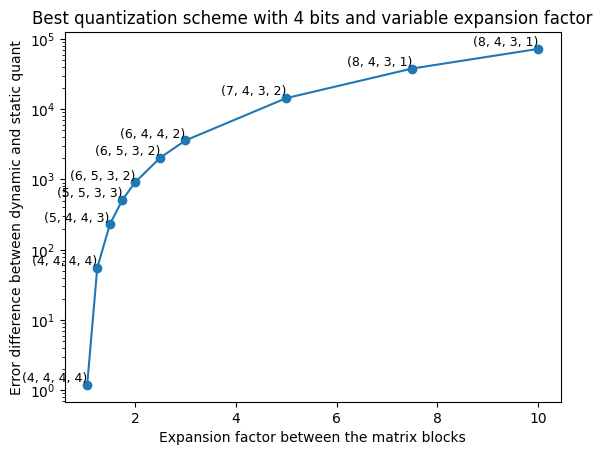

In [81]:
import matplotlib.pyplot as plt

print(best_combinations)
plt.plot(expansion_factors,best_scores,marker='o', linestyle='-')
plt.title('Best quantization scheme with 4 bits and variable expansion factor')
plt.xlabel('Expansion factor between the matrix blocks')
plt.ylabel('Error difference between dynamic and static quant')
plt.yscale('log')
for i, (x, y) in enumerate(zip(expansion_factors, best_scores)):
    plt.text(x, y, best_combinations[i], fontsize=9, ha='right', va='bottom')
plt.show()